In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from torch.optim import Adam
from tqdm import tqdm
import torch
import dataset_utils as data
import utils as utils

In [2]:
base_dir = "/home/mlsnrs/data/data/lff/ai-lab/lab3/"
data_dir = base_dir + "../../data/"
prefix = "textcnn_glove"

if not os.path.exists(f"model/{prefix}"):
    os.makedirs(f"model/{prefix}")

lr = 1e-3
decay = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 64
num_workers = 4
num_epochs = 50

In [3]:
# Load dataset
# train_set_imdb = data.ImdbDatasetLoader(f"{data_dir}/aclImdb/train")
data_weight = 1.0
train_set_imdb = None
# 
train_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/train.data")
dev_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/valid.data")

# building vocabulary
vocab, idx_to_word = data.build_vocab([
    train_set_imdb if train_set_imdb is not None else []
    , train_set, dev_set])

# word->idx
if train_set_imdb is not None:
    train_set_imdb.convert_word_to_idx(vocab)
train_set.convert_word_to_idx(vocab)
dev_set.convert_word_to_idx(vocab)

# samples: 8596
# samples: 1000


In [4]:
# pretrain words vector
import torchtext.vocab as Vocab

glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=os.path.join(data_dir+"/fudan_nlp/", "glove"))
print(len(glove_vocab.stoi)) # 400000
print(glove_vocab[0].shape)

vocab_weights = data.load_pretrained_embedding(vocab.keys(), glove_vocab)

400000
torch.Size([100])
There are 736 oov words.
['<pad>', '<unk>', '', 'eckstraordinarily', 'cletis', 'swordfights', 'completist', '�the', 'slappingly', 'clichand', 'gantzes', 'surfacey', 'reeboir', 'recurre', 'clich�s', 'g�nero', 'actuaci�n', 'perdona', 'gui�n', 'guessable', 'aceitou', 'continua��o', 'sa�do', 'pesquerdo', 'aqueles', 'decidiram', 'assistir', 'tamb�m', 'unimpressively', 'aborbing', 'histo', 'third�emotionally', 'coriat', 'miscasts', 'likableness', 'contando', 'premissa', 'mergulha', 'culminando', 'desfecho', 'certamente', 'mem�ria', 'enrapturing', 'clich�d', 'nonjudgmentally', 'bottomlessly', 'travil', 'clutchy', 'pistoled', 'vocsinta', 'necessidade', 't�rmino', 'proje��o', 'n�o', 'preocupe', 'ningu�m', 'lhe', 'enviarpenas', 'simbolizando', 'covardia', 'birot', 'wifty', 'wisegirls', 'nrelentingly', 'jirhubac', 'rintars', 'gabbiest', 'nonethnic', 'crummles', 'almod�var', 'logra', 'entra�able', 'compasi�n', 'comprensi�n', 'inolvidable', 'shimmeringly', 'schneidermeister

In [5]:
from textcnn import TextCNN


model =TextCNN(
    vocab_size=len(vocab),                
    embedding_dim=100, 
    pretrain_weights=vocab_weights,
    kernel_sizes=[3,4,5], num_channels=16,
    num_class=2,dropout1=0.1,dropout2=0.6
    )

print(model)

TextCNN(
  (embd): Embedding(17540, 100)
  (constant_embd): Embedding(17540, 100)
  (dropout_embd): Dropout(p=0.1, inplace=False)
  (dropout_conv): Dropout(p=0.6, inplace=False)
  (conv11): Conv2d(1, 16, kernel_size=(3, 200), stride=(1, 1))
  (conv12): Conv2d(1, 16, kernel_size=(4, 200), stride=(1, 1))
  (conv13): Conv2d(1, 16, kernel_size=(5, 200), stride=(1, 1))
  (fc): Linear(in_features=48, out_features=2, bias=True)
  (pool): GlobalMaxPool1d()
  (loss_ce): CrossEntropyLoss()
)


In [6]:
model.to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=decay) 


# train
loss_tr_his , acc_tr_his = [],[]
loss_dev_his , acc_dev_his = [],[]

the_best = {'eval_acc': 100,
            'model_path':''}

In [7]:
import utils as utils
loss_aux_his , acc_aux_his = [],[]

In [8]:
# train_set = dev_set
for epo in range(num_epochs): 
    # train once in imdb if not none
    # train once in fudan dataset
    if train_set_imdb is not None:
        (batch_avg_loss, batch_avg_acc),(
            l_,a_) = utils.train_batch_cross_domain(
            model, train_set, train_set_imdb, batch_size, num_workers, device,
            optimizer, weighted=data_weight)
            
        loss_aux_his.append(l_)
        acc_aux_his.append(a_)
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)

    else:
        batch_avg_loss, batch_avg_acc = utils.train_batch(
            model, train_set, batch_size, num_workers, device,
            optimizer)    
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)


    # eval once
    eval_loss, eval_acc, _, __ = utils.eval(model, dev_set, batch_size, num_workers, device)
    loss_dev_his.append(eval_loss)
    acc_dev_his.append(eval_acc)

    print(f"epoch[{epo}]  tr_loss: {batch_avg_loss}   tr_acc: {batch_avg_acc}   eval_loss: {eval_loss}   eval_acc: {eval_acc}")

    # save
    if eval_loss <= min(loss_dev_his):
        the_best['model_path'] =  f"model/{prefix}_best.pth"
        the_best['eval_acc'] =  eval_acc
        
        torch.save(model, the_best['model_path'])
        
        print(f"ckp: save as { the_best['model_path'] }, acc {the_best['eval_acc']}")

100%|██████████| 135/135 [00:04<00:00, 33.45it/s]


epoch[0]  tr_loss: 0.6589069548827499   tr_acc: 0.6140065146579805   eval_loss: 0.6128566702206929   eval_acc: 0.721
ckp: save as model/textcnn_glove_best.pth, acc 0.721


100%|██████████| 135/135 [00:02<00:00, 56.66it/s]


epoch[1]  tr_loss: 0.5804200706197254   tr_acc: 0.6983480688692415   eval_loss: 0.5720902780691782   eval_acc: 0.748
ckp: save as model/textcnn_glove_best.pth, acc 0.748


100%|██████████| 135/135 [00:02<00:00, 53.25it/s]


epoch[2]  tr_loss: 0.5581016022322783   tr_acc: 0.7124243834341554   eval_loss: 0.5595893184343974   eval_acc: 0.747
ckp: save as model/textcnn_glove_best.pth, acc 0.747


100%|██████████| 135/135 [00:02<00:00, 54.67it/s]


epoch[3]  tr_loss: 0.5398618358729491   tr_acc: 0.7360400186133085   eval_loss: 0.543501204252243   eval_acc: 0.763
ckp: save as model/textcnn_glove_best.pth, acc 0.763


100%|██████████| 135/135 [00:02<00:00, 57.86it/s]


epoch[4]  tr_loss: 0.5286893744522067   tr_acc: 0.7392973476035365   eval_loss: 0.5399736881256103   eval_acc: 0.77
ckp: save as model/textcnn_glove_best.pth, acc 0.77


100%|██████████| 135/135 [00:02<00:00, 54.06it/s]


epoch[5]  tr_loss: 0.5171421501618713   tr_acc: 0.7479060027919963   eval_loss: 0.5316278835137686   eval_acc: 0.774
ckp: save as model/textcnn_glove_best.pth, acc 0.774


100%|██████████| 135/135 [00:02<00:00, 55.70it/s]


epoch[6]  tr_loss: 0.5066265437140394   tr_acc: 0.7566309911586785   eval_loss: 0.5211449603239695   eval_acc: 0.776
ckp: save as model/textcnn_glove_best.pth, acc 0.776


100%|██████████| 135/135 [00:02<00:00, 56.56it/s]


epoch[7]  tr_loss: 0.49728587158580323   tr_acc: 0.7634946486738018   eval_loss: 0.5315133849779765   eval_acc: 0.764


100%|██████████| 135/135 [00:02<00:00, 54.81it/s]


epoch[8]  tr_loss: 0.49408373058731875   tr_acc: 0.7611679851093532   eval_loss: 0.5205412964026134   eval_acc: 0.772
ckp: save as model/textcnn_glove_best.pth, acc 0.772


100%|██████████| 135/135 [00:02<00:00, 57.28it/s]


epoch[9]  tr_loss: 0.48836604894986796   tr_acc: 0.7703583061889251   eval_loss: 0.529451459646225   eval_acc: 0.774


100%|██████████| 135/135 [00:02<00:00, 55.12it/s]


epoch[10]  tr_loss: 0.4749469930556283   tr_acc: 0.7774546300604932   eval_loss: 0.5323986152807871   eval_acc: 0.762


100%|██████████| 135/135 [00:02<00:00, 54.68it/s]


epoch[11]  tr_loss: 0.47081242724141076   tr_acc: 0.7791996277338297   eval_loss: 0.517578907807668   eval_acc: 0.77
ckp: save as model/textcnn_glove_best.pth, acc 0.77


100%|██████████| 135/135 [00:02<00:00, 55.38it/s]


epoch[12]  tr_loss: 0.4638689598485605   tr_acc: 0.7830386226151699   eval_loss: 0.5248817185560862   eval_acc: 0.762


100%|██████████| 135/135 [00:02<00:00, 54.09it/s]


epoch[13]  tr_loss: 0.464553944210508   tr_acc: 0.786063285248953   eval_loss: 0.5216217239697775   eval_acc: 0.772


100%|██████████| 135/135 [00:02<00:00, 55.94it/s]


epoch[14]  tr_loss: 0.4614588097849889   tr_acc: 0.782805956258725   eval_loss: 0.5233554263909658   eval_acc: 0.775


100%|██████████| 135/135 [00:02<00:00, 54.87it/s]


epoch[15]  tr_loss: 0.44987605801269187   tr_acc: 0.7871102838529549   eval_loss: 0.5169413248697917   eval_acc: 0.777
ckp: save as model/textcnn_glove_best.pth, acc 0.777


100%|██████████| 135/135 [00:02<00:00, 53.84it/s]


epoch[16]  tr_loss: 0.44997535112188825   tr_acc: 0.789320614239181   eval_loss: 0.5196867028872172   eval_acc: 0.77


100%|██████████| 135/135 [00:02<00:00, 54.43it/s]


epoch[17]  tr_loss: 0.43608299831845865   tr_acc: 0.804792926942764   eval_loss: 0.5261233747005463   eval_acc: 0.767


100%|██████████| 135/135 [00:02<00:00, 53.64it/s]


epoch[18]  tr_loss: 0.4441478488160603   tr_acc: 0.7986272684969753   eval_loss: 0.5287559926509857   eval_acc: 0.772


100%|██████████| 135/135 [00:02<00:00, 56.29it/s]


epoch[19]  tr_loss: 0.4342912980424824   tr_acc: 0.7996742671009772   eval_loss: 0.523068348566691   eval_acc: 0.778


100%|██████████| 135/135 [00:02<00:00, 56.67it/s]


epoch[20]  tr_loss: 0.4384326303183143   tr_acc: 0.799092601209865   eval_loss: 0.5253393510977428   eval_acc: 0.765


100%|██████████| 135/135 [00:02<00:00, 57.38it/s]


epoch[21]  tr_loss: 0.4346692272976263   tr_acc: 0.796649604467194   eval_loss: 0.526046633720398   eval_acc: 0.769


100%|██████████| 135/135 [00:02<00:00, 57.88it/s]


epoch[22]  tr_loss: 0.4191389203961216   tr_acc: 0.8111912517449976   eval_loss: 0.5308907310167948   eval_acc: 0.769


100%|██████████| 135/135 [00:02<00:00, 55.42it/s]


epoch[23]  tr_loss: 0.42442249384388997   tr_acc: 0.80746859004188   eval_loss: 0.5300550103187561   eval_acc: 0.77


100%|██████████| 135/135 [00:02<00:00, 56.94it/s]


epoch[24]  tr_loss: 0.4136835401182744   tr_acc: 0.8144485807352256   eval_loss: 0.5237092296282451   eval_acc: 0.775


100%|██████████| 135/135 [00:02<00:00, 55.71it/s]


epoch[25]  tr_loss: 0.41302467760310246   tr_acc: 0.809097254536994   eval_loss: 0.5219404995441437   eval_acc: 0.779


100%|██████████| 135/135 [00:02<00:00, 55.89it/s]


epoch[26]  tr_loss: 0.404396819312181   tr_acc: 0.8178222429036761   eval_loss: 0.5256597240765889   eval_acc: 0.769


100%|██████████| 135/135 [00:02<00:00, 53.08it/s]


epoch[27]  tr_loss: 0.40573287065794217   tr_acc: 0.8122382503489995   eval_loss: 0.5195445875326793   eval_acc: 0.774


100%|██████████| 135/135 [00:02<00:00, 55.68it/s]


epoch[28]  tr_loss: 0.40317608883131795   tr_acc: 0.8195672405770126   eval_loss: 0.5187464316685995   eval_acc: 0.795


100%|██████████| 135/135 [00:02<00:00, 53.35it/s]


epoch[29]  tr_loss: 0.39918959240860014   tr_acc: 0.8191019078641228   eval_loss: 0.5242100477218627   eval_acc: 0.771


100%|██████████| 135/135 [00:02<00:00, 55.64it/s]


epoch[30]  tr_loss: 0.3904721661290126   tr_acc: 0.8255002326663564   eval_loss: 0.5182106554508209   eval_acc: 0.778


100%|██████████| 135/135 [00:02<00:00, 54.87it/s]


epoch[31]  tr_loss: 0.4025902559063328   tr_acc: 0.8210795718939041   eval_loss: 0.5307533144950867   eval_acc: 0.762


100%|██████████| 135/135 [00:02<00:00, 55.08it/s]


epoch[32]  tr_loss: 0.3933543594025854   tr_acc: 0.8238715681712424   eval_loss: 0.5290975113709767   eval_acc: 0.775


100%|██████████| 135/135 [00:02<00:00, 56.73it/s]


epoch[33]  tr_loss: 0.3847516132379646   tr_acc: 0.8253838994881341   eval_loss: 0.5288842797279358   eval_acc: 0.774


100%|██████████| 135/135 [00:02<00:00, 55.80it/s]


epoch[34]  tr_loss: 0.39516223210897017   tr_acc: 0.8202652396463471   eval_loss: 0.5314675311247508   eval_acc: 0.764


100%|██████████| 135/135 [00:02<00:00, 54.95it/s]


epoch[35]  tr_loss: 0.3865307498334059   tr_acc: 0.8288738948348069   eval_loss: 0.5331246793270111   eval_acc: 0.768


100%|██████████| 135/135 [00:02<00:00, 53.73it/s]


epoch[36]  tr_loss: 0.38871947909469035   tr_acc: 0.8258492322010237   eval_loss: 0.5367969890435537   eval_acc: 0.762


100%|██████████| 135/135 [00:02<00:00, 56.47it/s]


epoch[37]  tr_loss: 0.3711706889209463   tr_acc: 0.8325965565379246   eval_loss: 0.5422700226306916   eval_acc: 0.764


100%|██████████| 135/135 [00:02<00:00, 51.32it/s]


epoch[38]  tr_loss: 0.38328958469540325   tr_acc: 0.8292228943694742   eval_loss: 0.5587944885094961   eval_acc: 0.767


100%|██████████| 135/135 [00:02<00:00, 55.06it/s]


epoch[39]  tr_loss: 0.3828128536245716   tr_acc: 0.8309678920428106   eval_loss: 0.536217067639033   eval_acc: 0.758


100%|██████████| 135/135 [00:02<00:00, 54.80it/s]


epoch[40]  tr_loss: 0.38578374094482676   tr_acc: 0.8293392275476966   eval_loss: 0.5384078621864319   eval_acc: 0.757


100%|██████████| 135/135 [00:02<00:00, 54.03it/s]


epoch[41]  tr_loss: 0.36592124802852743   tr_acc: 0.8384132154490461   eval_loss: 0.5462788681189219   eval_acc: 0.758


100%|██████████| 135/135 [00:02<00:00, 56.45it/s]


epoch[42]  tr_loss: 0.3721524197886239   tr_acc: 0.8356212191717077   eval_loss: 0.5494546731313069   eval_acc: 0.752


100%|██████████| 135/135 [00:02<00:00, 53.68it/s]


epoch[43]  tr_loss: 0.3682240842660861   tr_acc: 0.8345742205677059   eval_loss: 0.5400154749552409   eval_acc: 0.758


100%|██████████| 135/135 [00:02<00:00, 56.30it/s]


epoch[44]  tr_loss: 0.35829433365099467   tr_acc: 0.84004187994416   eval_loss: 0.5423232694466908   eval_acc: 0.76


100%|██████████| 135/135 [00:02<00:00, 53.50it/s]


epoch[45]  tr_loss: 0.3682260127432311   tr_acc: 0.8352722196370405   eval_loss: 0.5445337136586507   eval_acc: 0.763


100%|██████████| 135/135 [00:02<00:00, 53.75it/s]


epoch[46]  tr_loss: 0.3632634276551987   tr_acc: 0.8344578873894835   eval_loss: 0.5440720061461131   eval_acc: 0.768


100%|██████████| 135/135 [00:02<00:00, 53.73it/s]


epoch[47]  tr_loss: 0.3668341543247451   tr_acc: 0.8392275476966031   eval_loss: 0.5296690861384074   eval_acc: 0.762


100%|██████████| 135/135 [00:02<00:00, 54.95it/s]


epoch[48]  tr_loss: 0.3590841922742217   tr_acc: 0.8405072126570498   eval_loss: 0.5385290304819743   eval_acc: 0.764


100%|██████████| 135/135 [00:02<00:00, 55.00it/s]


epoch[49]  tr_loss: 0.35747309462792837   tr_acc: 0.8412052117263844   eval_loss: 0.5407015065352122   eval_acc: 0.753


In [9]:
def test_and_write(_data_iter, type="test"):
    preds= []

    for step, _batch in tqdm(enumerate(_data_iter)):
        model.eval()
        x,y=_batch
        with torch.no_grad():
            loss, pred = model(x.to(device), y.to(device))
            pred = pred.detach().cpu().numpy().tolist()
            preds.extend(pred)

    print(f'# {type} pred:', preds)

    with open(f'model/{prefix}/{type}_{len(loss_tr_his)}_res.txt',encoding="utf-8", mode='w') as f:
        for pred in preds:
            f.write("positive" if pred==1 else 'negative')
            f.write('\n')


## load the best model
model = torch.load(the_best['model_path'])


## 写出test结果到txt
test_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/test.data",test=True)

test_set.convert_word_to_idx(vocab)

test_data_iter=test_set.get_sequential_iter(batch_size, num_workers)
test_and_write(test_data_iter,type="test")

dev_data_iter= dev_set.get_sequential_iter(batch_size, num_workers)
test_and_write(dev_data_iter,type="valid")

# samples: 1066


17it [00:00, 44.92it/s]

# test pred: [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,


16it [00:00, 46.88it/s]

# valid pred: [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1

In [10]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_(losses:dict, acces:dict, save=None):
    num_fig = 2
    plt.figure(num_fig, figsize=(8, 8))
    plt.grid(True)
    
    plt.subplot(num_fig, 1, 1)

    data_f = pd.DataFrame(losses)
    sns.scatterplot(data=data_f)


    plt.subplot(num_fig, 1, 2)
    data_f = pd.DataFrame(acces)
    sns.scatterplot(data=data_f)
    
    plt.savefig(save)

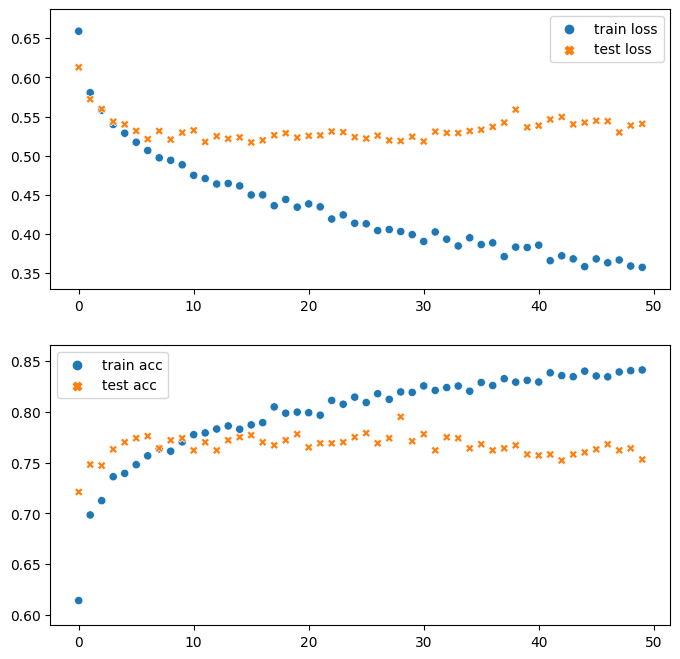

In [11]:
def plot():
    def get_cpu(tuples):
        new_his = []
        for t in tuples:
            new_his.append(t.cpu().item())
        return new_his

    ls = {"train loss":loss_tr_his,
          "test loss":loss_dev_his,
        #   "aux train loss": loss_aux_his
        }

    accs = {"train acc":acc_tr_his,
          "test acc":acc_dev_his,
        #   "aux train acc": acc_aux_his
        }
    plot_(ls, accs,  save =
          f"model/{prefix}/{len(acc_tr_his)}-{the_best['eval_acc']}.png")


plot()

In [12]:
print("best eval loss:", min(loss_dev_his))
print("best eval acc:", max(acc_dev_his))

print("best train loss:", min(loss_tr_his))
print("best train acc:", max(acc_tr_his))

best eval loss: 0.5169413248697917
best eval acc: 0.795
best train loss: 0.35747309462792837
best train acc: 0.8412052117263844
